#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 3: Demanda de bicicletas compartidas  </center>

# Introducción

En esta actividad se trabajará sobre el *dataset* de la competencia [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand) de *Kaggle*. El objetivo de la competencia, predecir la demanda de bicicletas a partir de la combinación de datos históricos sobre demanda y clima.

El conjunto corresponde a datos de alquiler por hora y abarcan dos años de información. El subconjunto de *train* está compuesto por los primeros 19 días de cada mes, mientras que el subconjunto de *test* va desde 20 hasta el final del mes. Este último debe ser utilizado solamente en la parte 10 para subir los resultados a la página de la competencia.

En esta actividad nos centraremos en el algoritmo **Decision Trees**, el cual al igual que *SVM* es un algoritmo versatil que se utiliza en problemas tanto de clasificación como de regresión. También trabajaremos con algoritmos basados en métodos de ensamble de estimadores, como son **Random Forest** y **Gradient Boosting**, que utilizan como estimador base **Decision Trees**.


## Objetivos


*   Conocer los estimadores *Decision Trees*, entender cómo funcionan para un problema de regresión, ver ventajas y desventajas.
*   Familiarizarse con los métodos de ensamblado de estimadores y entender cual es el objetivo de usar estos métodos.
*   Incorporar una función de transformación de columnas y una función de medida de desempeño personalizadas.


## Formas de trabajo

#### Opción 1: Trabajar localmente

##### Descarga de datos disponibles en Kaggle

Luego, para descargar el dataset de IMDb reviews:

In [ ]:
!kaggle competitions download -c bike-sharing-demand

Descomprima el archivo descargado:

In [ ]:
import shutil
shutil.unpack_archive('./bike-sharing-demand.zip', './')

#### Opción 2:  Trabajar en *Colab*.

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`.

La siguiente celda monta el disco personal del drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A continuación, vaya a su cuenta de [Kaggle](https://www.kaggle.com/) (o cree una si aún no lo ha hecho), haga clic en el icono de perfil en la esquina superior derecha de la pantalla y seleccione "Your Account" en la lista desplegable. Luego, seleccione la viñeta "Account" y haga clic en "Create new API token". Entonces un archivo llamado kaggle.json se descargará automáticamente a su carpeta de descargas. Este archivo contiene sus credenciales de inicio de sesión para permitirle acceder a la API.

La siguiente celda realiza la configuración necesaria para obtener datos desde la plataforma Kaggle. Le solicitará que suba el archivo kaggle.json descargado anteriormente.

In [3]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


Una vez guardado el *token* se pueden descargar los datos, en este caso se bajarán los datos del dataset IMDb reviews:

In [4]:
!kaggle competitions download -c bike-sharing-demand

In [5]:
!unzip bike-sharing-demand.zip

Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2025/blob/main/talleres/taller3_demanda_de_bicicletas.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

## Paquetes a utilizar

En esta actividad se utilizarán algunas bibliotecas auxiliares que deberán ser instaladas. Ejecutar la siguiente celda hasta que se ejecute sin errores. En caso de error, se puede instalar el paquete faltante desde el notebook con el comando:

`!pip install paquete_faltante`

In [8]:
!pip install comet_ml

import comet_ml
from comet_ml import Experiment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### (Opcional) librería de visualización de datos
import seaborn as sns
sns.set_theme(style="whitegrid")

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


## Parte 1 - Análisis de los datos

#### Objetivos

 - Analizar el conjunto de datos con las diferentes funciones de *pandas* que crea pertinente.

In [9]:
# 1. Exploración inicial del conjunto de datos
print("Primeras filas del conjunto de entrenamiento:")
print(df_train.head())

print("\nInformación general del conjunto de entrenamiento:")
print(df_train.info())

# 2. Estadísticas descriptivas
print("\nEstadísticas descriptivas del conjunto de entrenamiento:")
print(df_train.describe())

Primeras filas del conjunto de entrenamiento:
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  

Información general del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column 

#### Preguntas:

 - ¿Qué efecto tiene el tiempo (meteorológico) sobre el alquiler de bicicletas? ¿Es el mismo para clientes registrados y casuales? ¿Coincide esto con lo que asumiría a priori?
 - Vamos a trabajar con las codificaciones por defecto (salvo datetime que veremos en la Parte 2). ¿Le parece adecuado?
 - ¿Qué puede decir sobre la correlación entre *season* y *casual*?


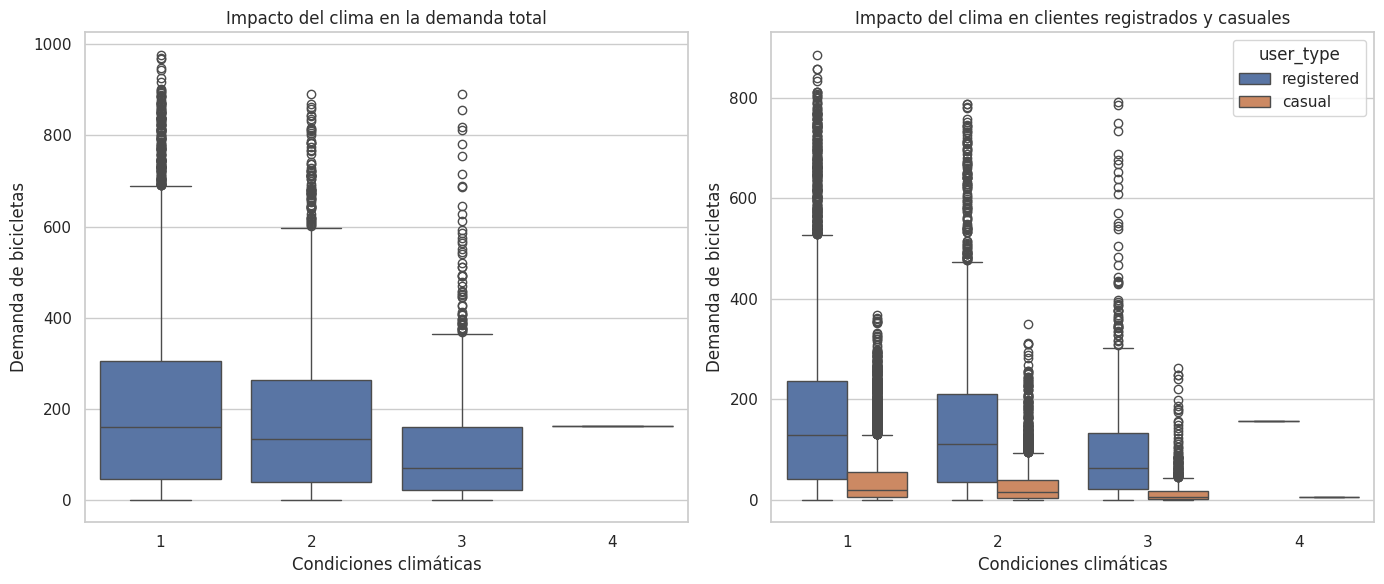

In [10]:
# Dividir la demanda total en 'registered' y 'casual'
plt.figure(figsize=(14, 6))

# Efecto del clima en la demanda total
plt.subplot(1, 2, 1)
sns.boxplot(data=df_train, x='weather', y='count')
plt.title('Impacto del clima en la demanda total')
plt.xlabel('Condiciones climáticas')
plt.ylabel('Demanda de bicicletas')

# Efecto del clima en clientes registrados y casuales
plt.subplot(1, 2, 2)
df_weather_effect = df_train.melt(id_vars='weather', value_vars=['registered', 'casual'],
                                  var_name='user_type', value_name='demand')
sns.boxplot(data=df_weather_effect, x='weather', y='demand', hue='user_type')
plt.title('Impacto del clima en clientes registrados y casuales')
plt.xlabel('Condiciones climáticas')
plt.ylabel('Demanda de bicicletas')
plt.tight_layout()
plt.show()

1. ¿Qué efecto tiene el tiempo (meteorológico) sobre el alquiler de bicicletas? ¿Es el mismo para clientes registrados y casuales? ¿Coincide esto con lo que asumiría a priori?
Análisis:
El tiempo meteorológico puede tener un impacto significativo en la demanda de bicicletas. Variables como la temperatura (temp), sensación térmica (atemp), humedad (humidity) y condiciones climáticas (weather) suelen influir en las decisiones de los usuarios.

Clientes registrados vs. casuales :
Los clientes registrados (usuarios frecuentes) pueden ser menos sensibles a las condiciones meteorológicas adversas, ya que probablemente usen las bicicletas como parte de su rutina diaria. En contraste, los usuarios casuales (ocasionales) podrían ser más propensos a cancelar o evitar el uso de bicicletas en condiciones inclementes.

---

2. Vamos a trabajar con las codificaciones por defecto (salvo datetime que veremos en la Parte 2). ¿Le parece adecuado?
Análisis:
El conjunto de datos incluye variables categóricas como season, holiday, workingday y weather. Estas variables están codificadas numéricamente (por ejemplo, season tiene valores 1, 2, 3, 4 para primavera, verano, otoño e invierno respectivamente). Sin embargo, estas codificaciones son ordinales y no reflejan relaciones de orden real entre las categorías.

Codificación por defecto :
Trabajar con las codificaciones por defecto es adecuado si se utiliza un modelo que no asume relaciones de orden entre las categorías (como Decision Trees o Random Forest ). Estos modelos tratan las variables categóricas como características discretas sin interpretarlas como ordinales.
Codificación alternativa :
Si se planea usar modelos que asumen relaciones lineales (como regresión lineal), sería mejor utilizar una codificación one-hot encoding para evitar suposiciones incorrectas sobre el orden de las categorías.
Conclusión:
Trabajar con las codificaciones por defecto es adecuado para los modelos basados en árboles (Decision Trees , Random Forest , Gradient Boosting ), pero si se planea usar otros modelos, puede ser necesario aplicar one-hot encoding .

Correlación entre 'season' y 'casual': 0.10


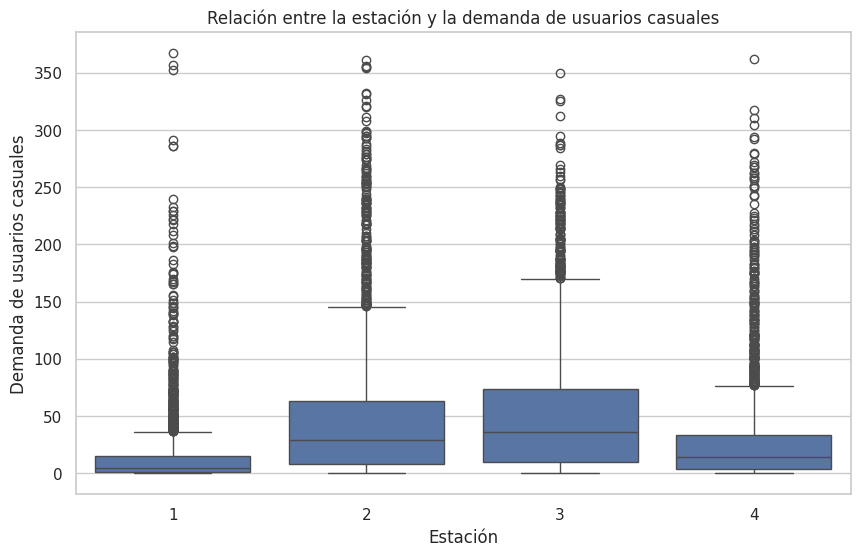

In [11]:
# Calcular la correlación entre 'season' y 'casual'
correlation_season_casual = df_train['season'].corr(df_train['casual'])
print(f"Correlación entre 'season' y 'casual': {correlation_season_casual:.2f}")

# Visualizar la relación
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='season', y='casual')
plt.title('Relación entre la estación y la demanda de usuarios casuales')
plt.xlabel('Estación')
plt.ylabel('Demanda de usuarios casuales')
plt.show()

La variable season representa la estación del año (1: primavera, 2: verano, 3: otoño, 4: invierno), mientras que casual representa la cantidad de usuarios casuales.

La correlación entre season y casual puede ser positiva o negativa dependiendo de los patrones de uso.
Generalmente, se espera que la demanda de usuarios casuales sea mayor en primavera y verano (estaciones más cálidas) y menor en invierno (estación más fría).
El gráfico de caja mostrará cómo la demanda de usuarios casuales varía según la estación.

## Parte 2 - Características temporales

La primer columna de los datos (*datetime*) corresponde a las marcas de tiempo asociadas a cada instancia. Para que estos tengan el orden cronológico que representan es necesario pasarlos de tipo *string* a tipo *datetime*. Para esto *Pandas* proporciona la función *to_datetime()*. Correr la siguiente celda para hacer el cambio.

In [12]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

##### La figura siguiente muestra cómo varía la cantidad de bicicletas alquiladas en función del tiempo.

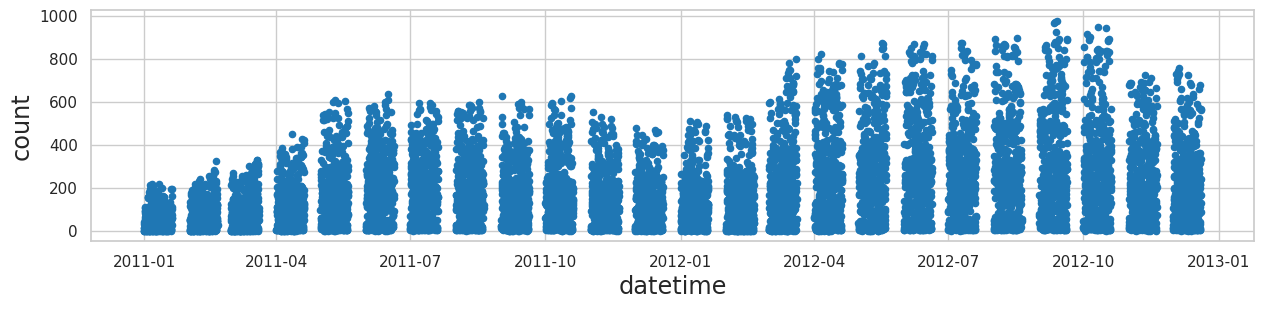

In [13]:
df_train.plot(x='datetime', y='count', figsize=[15,3],kind='scatter',color='tab:blue')
plt.xlabel('datetime',fontsize='x-large')
plt.ylabel('count',fontsize='x-large')
plt.show()

#### Preguntas:

- ¿Le parece razonable la division en conjuntos de train y test que se tomó en el desafío?
- ¿Cómo varían temporalmente (día, semana, mes, año) los alquileres?

<p style="font-size:13px; color:#BB0000;">Respuesta a preguntas </p>

1. ¿Le parece razonable la división en conjuntos de train y test que se tomó en el desafío?
La división del conjunto de datos en entrenamiento (train ) y prueba (test ) sigue un patrón temporal específico:

El subconjunto de entrenamiento (df_train) incluye los primeros 19 días de cada mes.
El subconjunto de prueba (df_test) abarca desde el día 20 hasta el final del mes.
Esta división tiene sentido para varios motivos:

Preservación del orden cronológico :
Al dividir los datos por días dentro de cada mes, se mantiene el orden temporal. Esto es crucial porque la demanda de bicicletas puede estar influenciada por patrones estacionales o temporales (por ejemplo, tendencias diarias, semanales o mensuales). Si los datos no se dividen temporalmente, podríamos introducir sesgos al mezclar información futura con la del pasado durante el entrenamiento
.
Generalización a nuevos periodos :
Al reservar los últimos días de cada mes para el conjunto de prueba, evaluamos cómo el modelo generaliza a períodos de tiempo distintos a aquellos utilizados para su entrenamiento. Esto es especialmente importante en problemas de series temporales, donde el objetivo es predecir valores futuros basándose en patrones históricos.
Cobertura de variabilidad :
La división asegura que tanto el conjunto de entrenamiento como el de prueba cubran una variedad de condiciones climáticas y temporales. Por ejemplo, los primeros 19 días de cada mes pueden incluir diferentes patrones de demanda dependiendo de si son días laborables, fines de semana o festivos.
Posibilidad de validación cruzada temporal :
Esta división también facilita la implementación de técnicas de validación cruzada específicas para series temporales, como Time Series Cross-Validation , donde los conjuntos de validación siempre vienen después de los conjuntos de entrenamiento en el tiempo.

---

2. ¿Cómo varían temporalmente (día, semana, mes, año) los alquileres?
Para analizar cómo varían los alquileres temporalmente, podemos observar la gráfica proporcionada y realizar un análisis más detallado utilizando características temporales extraídas de la columna datetime. A continuación, se describen los patrones observados:

Gráfica general:
La gráfica muestra la cantidad de bicicletas alquiladas (count) en función del tiempo (datetime). Se observan varias tendencias:

Tendencia general ascendente :
Durante el período analizado (2011-2012), hay una tendencia general hacia un aumento en la demanda de bicicletas. Esto podría indicar un crecimiento en el uso de bicicletas compartidas a lo largo del tiempo.
Variaciones estacionales :
Existen patrones repetitivos que sugieren variaciones estacionales. Por ejemplo:
Los picos de demanda parecen coincidir con ciertos meses del año (posiblemente primavera y verano).
Las bajas demandas ocurren en otros meses (posiblemente invierno).
Fluctuaciones semanales/diarias :
Aunque no se ven claramente en la escala actual, es probable que existan patrones semanales (pico de demanda durante días laborables) y diarios (pico de demanda durante horas pico de tráfico).
Análisis detallado de variaciones temporales:
Por día:
Es probable que la demanda sea mayor durante días laborables y menor durante fines de semana. Además, los días con buen clima tienden a tener más alquileres que los días lluviosos o fríos.
Por semana:
La demanda suele ser cíclica a lo largo de la semana, con picos durante días laborables y caídas durante fines de semana. Este patrón está relacionado con el uso de bicicletas para desplazamientos cotidianos.
Por mes:
La demanda parece seguir un patrón estacional:
Verano (junio-agosto) : Mayor demanda debido al clima favorable.
Invierno (diciembre-febrero) : Menor demanda debido al clima frío y húmedo.
Primavera y otoño : Demandas moderadas, aunque pueden variar según las condiciones climáticas específicas.
Por año:
La tendencia general muestra un aumento en la demanda a lo largo de los años. Esto podría deberse a factores como un mayor interés en el uso de bicicletas compartidas, mejoras en la infraestructura ciclista o campañas de promoción.

El tipo de dato *datetime* permite extraer de forma sencilla datos categóricos como la hora, el día de la semana, entre otros. La siguiente celda agrega a los datos de *train* estas nuevas características.

In [14]:
df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday

df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5


#### Ejercicio:

 - Grafique count, registered y casual en función de las horas y el día de la semana. ([*Sugerencia:*](https://seaborn.pydata.org/generated/seaborn.barplot.html) Ejemplos de la librería *seaborn*)

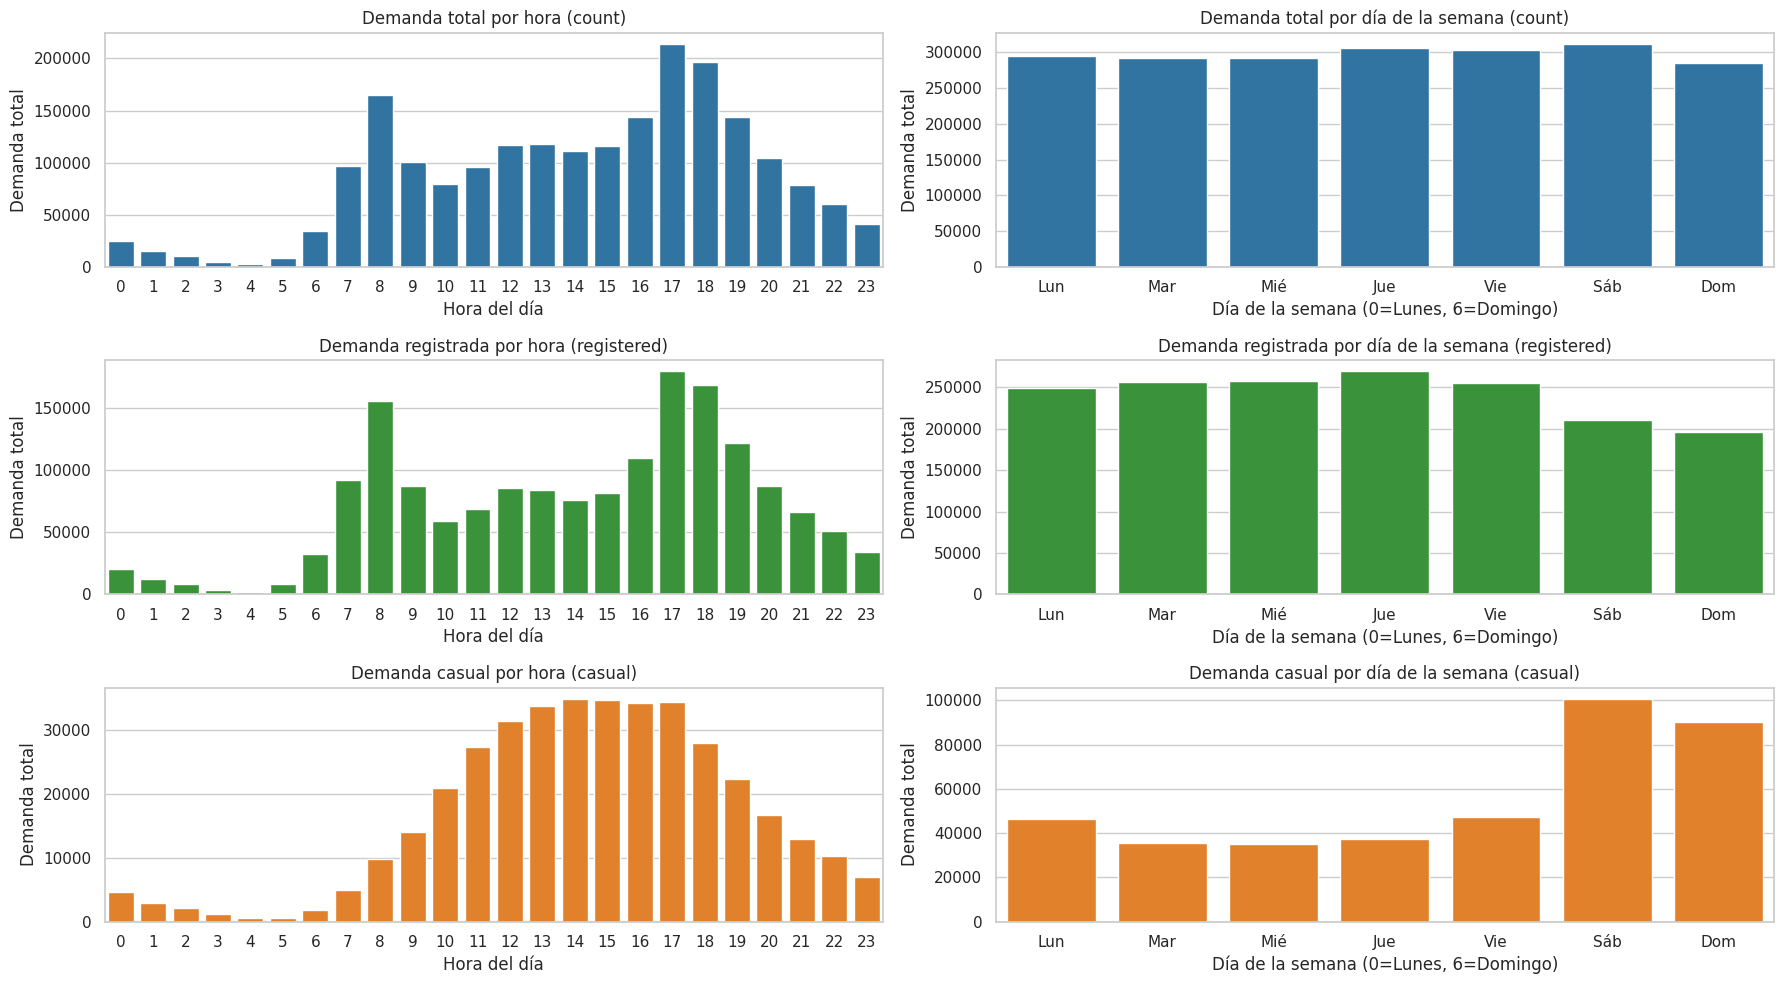

In [15]:
# 1. Gráfico de count, registered y casual en función de las horas
plt.figure(figsize=(18, 10))

# Gráfico para 'count'
plt.subplot(3, 2, 1)
sns.barplot(data=df_train, x='hour', y='count', estimator=sum, ci=None, color='tab:blue')
plt.title('Demanda total por hora (count)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda total')

# Gráfico para 'registered'
plt.subplot(3, 2, 3)
sns.barplot(data=df_train, x='hour', y='registered', estimator=sum, ci=None, color='tab:green')
plt.title('Demanda registrada por hora (registered)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda total')

# Gráfico para 'casual'
plt.subplot(3, 2, 5)
sns.barplot(data=df_train, x='hour', y='casual', estimator=sum, ci=None, color='tab:orange')
plt.title('Demanda casual por hora (casual)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda total')

# 2. Gráfico de count, registered y casual en función del día de la semana
# Gráfico para 'count'
plt.subplot(3, 2, 2)
sns.barplot(data=df_train, x='weekday', y='count', estimator=sum, ci=None, color='tab:blue')
plt.title('Demanda total por día de la semana (count)')
plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
plt.ylabel('Demanda total')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

# Gráfico para 'registered'
plt.subplot(3, 2, 4)
sns.barplot(data=df_train, x='weekday', y='registered', estimator=sum, ci=None, color='tab:green')
plt.title('Demanda registrada por día de la semana (registered)')
plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
plt.ylabel('Demanda total')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

# Gráfico para 'casual'
plt.subplot(3, 2, 6)
sns.barplot(data=df_train, x='weekday', y='casual', estimator=sum, ci=None, color='tab:orange')
plt.title('Demanda casual por día de la semana (casual)')
plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
plt.ylabel('Demanda total')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

plt.tight_layout()
plt.show()

##### A partir de las gráficas responder las siguientes preguntas:

 - ¿Cómo explicaría la diferencia entre las distribuciones de los clientes registrados y casuales?
 - ¿Qué desventaja le encuentra a utilizar un regresor lineal para predecir los alquileres a partir de la hora del día?¿Cómo transformaría esta característica para paliar este problema?
 - ¿Es necesaria esta transformación cuando se utilizan Árboles de Decisión?

## 1. ¿Cómo explicaría la diferencia entre las distribuciones de los clientes registrados y casuales?
Las gráficas muestran diferencias significativas en la demanda entre clientes registrados y casuales tanto en función de la hora del día como del día de la semana:

Clientes registrados (Registered):
La demanda es más consistente durante las horas pico de tráfico, especialmente entre las 8 AM y 6 PM , lo que sugiere un uso predominante para desplazamientos cotidianos relacionados con el trabajo o estudios
.
Durante los días laborables (lunes a viernes), la demanda es mucho mayor que los fines de semana, indicando que estos usuarios dependen principalmente de las bicicletas para desplazamientos diarios.
Clientes casuales (Casual):
La demanda es más baja durante las horas pico de tráfico y se incrementa durante horas de ocio, como la tarde y la noche (por ejemplo, alrededor de las 12 PM y 18 PM ).
Los fines de semana (sábado y domingo) tienen una demanda más alta que durante los días laborables, lo que indica que los usuarios casuales suelen usar las bicicletas para actividades recreativas o no rutinarias.
Explicación de las diferencias:
Objetivos de uso:
Los clientes registrados tienden a usar las bicicletas como parte de sus rutinas diarias, mientras que los clientes casuales lo hacen principalmente para actividades recreativas o ocasionales. Esto explica por qué la demanda de usuarios registrados es más alta durante las horas pico de tráfico y disminuye drásticamente los fines de semana.
Sensibilidad al clima:
Los usuarios casuales pueden ser más sensibles a las condiciones climáticas adversas (como lluvia o frío), lo que reduce su demanda durante días inclementes. En contraste, los usuarios registrados son menos afectados por estas condiciones porque su uso está vinculado a necesidades más estructuradas.
Patrones temporales:
Las gráficas muestran que los usuarios registrados siguen patrones más estables y predecibles, mientras que los usuarios casuales presentan variaciones más aleatorias, dependiendo de factores como el tiempo libre y las actividades recreativas.

---

## 2. ¿Qué desventaja le encuentra a utilizar un regresor lineal para predecir los alquileres a partir de la hora del día? ¿Cómo transformaría esta característica para paliar este problema?
Desventaja del regresor lineal:
Un regresor lineal asume una relación lineal entre las variables predictoras y la variable objetivo. Sin embargo, la demanda de bicicletas en función de la hora del día suele tener un patrón cíclico (periódico), ya que la demanda repite ciertos patrones cada 24 horas. Por ejemplo:

La demanda aumenta durante las horas pico de tráfico (mañana y tarde).
Disminuye durante las horas nocturnas y tempranas de la mañana.
Un modelo lineal no puede capturar esta periodicidad natural debido a su suposición de linealidad. Si se utiliza directamente la hora del día como variable numérica, el modelo podría interpretarla como una relación continua estrictamente creciente o decreciente, lo cual no refleja la realidad
.

Transformación para paliar el problema:
Para capturar la periodicidad de la demanda, se puede transformar la característica "hora del día" utilizando funciones trigonométricas (seno y coseno). Esta técnica convierte la variable cíclica en dos dimensiones ortogonales que representan la periodicidad:

Hora_seno=sin(
24
2π⋅hour
​
 )
Hora_coseno=cos(
24
2π⋅hour
​
 )
Estas transformaciones permiten que el modelo capture la naturaleza periódica de la demanda sin asumir una relación lineal continua. Al agregar estas nuevas características, el modelo puede aprender patrones cíclicos más complejos.

---

## 3. ¿Es necesaria esta transformación cuando se utilizan Árboles de Decisión?
No, la transformación de la característica "hora del día" no es necesaria cuando se utilizan Árboles de Decisión o modelos basados en árboles (como Random Forest o Gradient Boosting). Estos modelos no asumen relaciones lineales entre las variables y pueden capturar patrones no lineales y cíclicos mediante particiones jerárquicas.

Por ejemplo:

Un Árbol de Decisión puede dividir fácilmente los datos en rangos horarios específicos (por ejemplo, "0-6 AM", "7-9 AM", etc.) para capturar las diferentes patrones de demanda.
Estos modelos pueden identificar automáticamente las horas pico y las horas de menor demanda sin necesidad de transformar la variable.
Sin embargo, aunque no sea estrictamente necesario, la transformación trigonométrica aún puede mejorar el rendimiento de los modelos basados en árboles en algunos casos, especialmente si la periodicidad es muy marcada y los árboles tardan en capturarla de manera eficiente.

#### Selección de Características:

*   Entre el día, el mes y el año ¿cuáles de estos datos les pareces agregar como nuevas características y cuáles no? y ¿Por qué?
*   Agregar las características seleccionadas.

In [16]:
# Agregar características temporales relevantes
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month

# Mostrar las primeras filas del DataFrame actualizado
print(df_train.head())

             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  hour  weekday  year  month  
0        81        0.0       3          13     16     0        5  2011      1  
1        80        0.0       8          32     40     1        5  2011      1  
2        80        0.0       5          27     32     2        5  2011      1  
3        75        0.0       3          10     13     3        5  2011      1  
4        75        0.0       0           1      1     4        5  2011      1  


## Parte 3 - Preparación de los datos y Métrica de evaluación

Previo a trabajar con los estimadores:

*   Apartar la columna objetivo y eliminarla del conjunto de entrenamiento.
*   Eliminar las columnas *'casual'* y *'registered'*. ¿Por qué esto es necesario?.
*   Eliminar la columna *'datetime'*.

Durante la actividad los estimadores deben ser evaluados con la misma medida de desempeño utilizada en la competencia:

Root Mean Squared Logarithmic Error (RMSLE)
$$\sqrt{\frac{1}{n}\sum_{i}^{n}\big(\log(y_{i} + 1) - \log(\hat{y}_{i} + 1)\big)^2}$$

Este tipo de medida se utiliza cuando los valores a estimar son grandes. La librería *Scikit-Learn* incluye la función de desempeño [*mean_squared_log_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE), esta función se puede utilizar  para la validación ya que alcanza las mismas soluciones que su raíz (RMSLE). De igual forma los resultados se deben mostrar con RMSLE.

In [18]:
from sklearn.metrics import mean_squared_log_error

# Separar la columna objetivo (count)
y_train = df_train['count']

# Eliminar las columnas 'count', 'casual', 'registered' y 'datetime'
X_train = df_train.drop(columns=['count', 'casual', 'registered', 'datetime'])

# Mostrar las primeras filas del conjunto de características
print("Características (X_train):")
print(X_train.head())

# Mostrar las primeras filas de la variable objetivo
print("\nVariable objetivo (y_train):")
print(y_train.head())

# Función para calcular RMSLE
def rmsle(y_true, y_pred):
    """
    Calcula el Root Mean Squared Logarithmic Error (RMSLE).
    :param y_true: Valores reales.
    :param y_pred: Valores predichos.
    :return: RMSLE.
    """
    msle = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(msle)

Características (X_train):
   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   hour  weekday  year  month  
0     0        5  2011      1  
1     1        5  2011      1  
2     2        5  2011      1  
3     3        5  2011      1  
4     4        5  2011      1  

Variable objetivo (y_train):
0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64


## Parte 4 - Decision Trees

### TransformedTargetRegressor

Observando los valores de las etiquetas se puede ver que la distribución de estos tiene una asimetría a la derecha, por lo que se puede aplicar una transformación logarítmica para que la distribución de las etiquetas sea más normal.

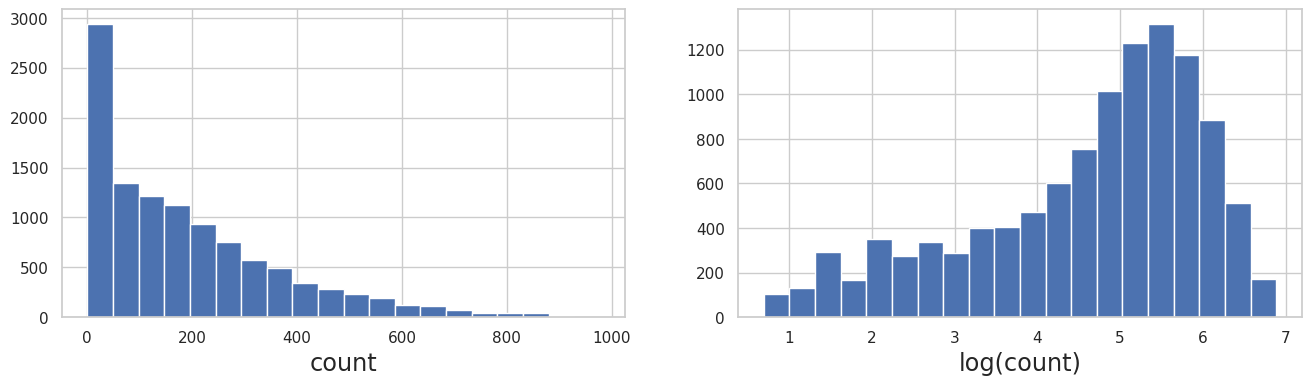

In [19]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
y_train.hist(bins=20)
plt.xlabel('count',fontsize='x-large')
plt.subplot(1,2,2)
np.log1p(y_train).hist(bins=20)
plt.xlabel('log(count)',fontsize='x-large')
plt.show()

Si le pasamos al regresor estas etqiquetas tranformadas este predecirá el logaritmo de los alquileres, por lo que luego deberíamos calcular la exponencial del valor predicho. Por suerte, Scikit-Learn cuenta con la función [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) que resuelve este problema.

**Nota: Consultar el Capítulo 2 del Libro del Curso por más información**

#### Objetivos

*   Importar la función *DecisionTreeRegressor()* de *Scikit-Learn* y utilizar *TransformedTargetRegressor* para tranformar logarítmicamente las etiquetas. Utilizar las funciones ***np.log1p*** y ***np.expm1*** para calcular el logaritmo y la exponencial respectivamente (ver ejemplo en ayuda de la función *TransformedTargetRegressor*).
*   Aplicar validación cruzada (10-Folds) a un estimador con los hiper-parámetros por defecto.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Para lo último utilizar la función *fill_between()* de *matplotlib*.

**Nota:** Puede pasarle ***random-state=2*** al estimador,*DecisionTreeRegressor()*,  para controlar la aleatoreidad del mismo. De no hacerlo puede que los resultados que obtenga difieran en cierta medida de los esperados.

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, KFold

# Definir el regresor base
base_regressor = DecisionTreeRegressor(random_state=2)

# Crear un regresor con TransformTargetRegressor
regressor = TransformedTargetRegressor(
    regressor=base_regressor,
    func=np.log1p,  # Transformación logarítmica
    inverse_func=np.expm1  # Inversa de la transformación
)

In [33]:
# Configurar la validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=2)

# Lista para almacenar los scores de entrenamiento y validación
rmsle_train_scores = []
rmsle_val_scores = []

# Iterar sobre cada fold
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenar el modelo
    regressor.fit(X_train_fold, y_train_fold)

    # Predecir en el conjunto de entrenamiento y validación
    y_pred_train = regressor.predict(X_train_fold)
    y_pred_val = regressor.predict(X_val_fold)

    # Calcular RMSLE para ambos conjuntos
    rmsle_train = rmsle(y_train_fold, y_pred_train)
    rmsle_val = rmsle(y_val_fold, y_pred_val)

    # Guardar los scores
    rmsle_train_scores.append(rmsle_train)
    rmsle_val_scores.append(rmsle_val)

# Calcular la media y desviación estándar de los scores
mean_rmsle_train = np.mean(rmsle_train_scores)
std_rmsle_train = np.std(rmsle_train_scores)
mean_rmsle_val = np.mean(rmsle_val_scores)
std_rmsle_val = np.std(rmsle_val_scores)

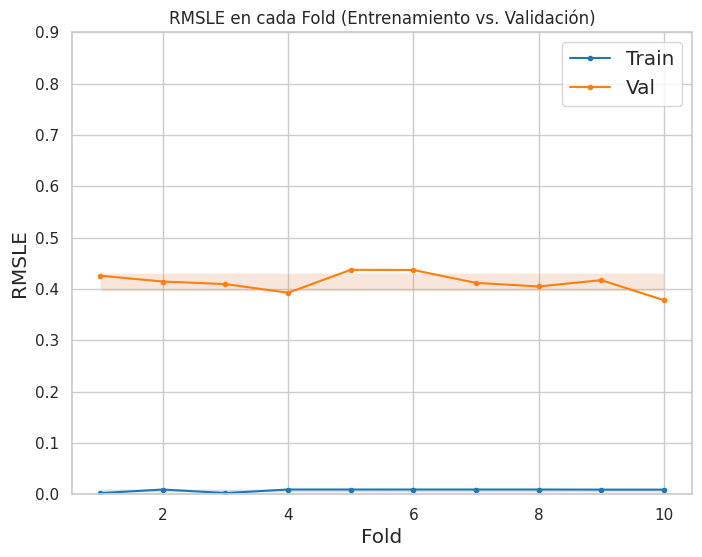

In [34]:
### Ayuda de Gráfica
# Se crea la figura
plt.figure(figsize=(8, 6))

# Graficar los valores de RMSLE de entrenamiento y validación
plt.plot(range(1, 11), rmsle_train_scores, '.-', color='tab:blue', label='Train')
plt.plot(range(1, 11), rmsle_val_scores, '.-', color='tab:orange', label='Val')

# Graficar la media y desviación estándar
plt.fill_between(np.arange(1, 11), mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2)
plt.fill_between(np.arange(1, 11), mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2)

# Configurar etiquetas y límites
plt.xlabel('Fold', fontsize='large')
plt.ylabel('RMSLE', fontsize='large')
plt.legend(fontsize='large')
plt.ylim([0, 0.9])
plt.title('RMSLE en cada Fold (Entrenamiento vs. Validación)')
plt.show()

#### Preguntas:

*   ¿Qué fenómeno se logra apreciar en el gráfico? ¿A qué se debe? ¿Por qué esto es un problema?
*   Indicar y describir alguno de los hiper-parámetros que la función *DecisionTreeRegressor()* ofrece para limitar la complejidad del estimador.

## 1. ¿Qué fenómeno se logra apreciar en el gráfico? ¿A qué se debe? ¿Por qué esto es un problema?
El gráfico muestra los valores de RMSLE (Root Mean Squared Logarithmic Error) para cada fold durante la validación cruzada, tanto para el conjunto de entrenamiento (Train) como para el conjunto de validación (Val). A continuación, analizamos los fenómenos observados:

Fenómeno observado:
Entrenamiento (Train):
El RMSLE en el conjunto de entrenamiento es muy bajo y prácticamente constante cerca de 0. Esto indica que el modelo ajusta perfectamente al conjunto de entrenamiento.
Validación (Val):
El RMSLE en el conjunto de validación es significativamente más alto (alrededor de 0.4) y muestra cierta variabilidad entre los folds. Además, hay una clara brecha entre los valores de RMSLE en el conjunto de entrenamiento y el de validación.
¿A qué se debe este fenómeno?
Este fenómeno sugiere sobreajuste del modelo:

El modelo está memorizando los datos de entrenamiento en lugar de aprender patrones generales.
La baja variabilidad en el RMSLE del conjunto de entrenamiento indica que el modelo está demasiado especializado en los datos específicos de entrenamiento.
La diferencia entre los RMSLE de entrenamiento y validación indica que el modelo no generaliza bien a datos no vistos.
¿Por qué esto es un problema?
El sobreajuste es un problema porque:

Pérdida de generalización: El modelo no será capaz de predecir bien nuevos datos que no estén presentes en el conjunto de entrenamiento.
Inestabilidad: Los resultados pueden variar significativamente cuando se aplican a datos reales o diferentes conjuntos de prueba.
Subutilización del modelo: Un modelo que sobreajusta no explota su capacidad para capturar relaciones útiles en los datos.
Para resolver esto, es necesario limitar la complejidad del modelo utilizando hiperparámetros adecuados.

---

## 2. Indicar y describir alguno de los hiper-parámetros que la función DecisionTreeRegressor() ofrece para limitar la complejidad del estimador.
La función DecisionTreeRegressor() de Scikit-Learn proporciona varios hiperparámetros para controlar la complejidad del árbol de decisión y evitar el sobreajuste. A continuación, se describen algunos de estos hiperparámetros clave:

1. max_depth:
Descripción: Define la profundidad máxima del árbol. Limita cuántas veces el árbol puede dividir los datos antes de detenerse.
Efecto: Reducir max_depth evita que el árbol crezca demasiado profundo y capture ruido en los datos.
Uso recomendado: Establecer un valor moderado (por ejemplo, max_depth=5 o max_depth=10) para equilibrar el ajuste y la generalización.
2. min_samples_split:
Descripción: Especifica el número mínimo de muestras requeridas para que un nodo interno se divida en dos subnodos.
Efecto: Incrementar min_samples_split hace que el árbol sea menos probable de dividir nodos con pocos ejemplos, lo que reduce la complejidad.
Uso recomendado: Valores comunes son min_samples_split=2 (valor por defecto) o valores mayores si se sospecha sobreajuste.
3. min_samples_leaf:
Descripción: Define el número mínimo de muestras requeridas para que un nodo pueda ser considerado hoja (sin dividirse más).
Efecto: Incrementar min_samples_leaf evita que el árbol cree ramas muy finas que solo representen ruido.
Uso recomendado: Valores comunes son min_samples_leaf=1 (valor por defecto) o valores mayores si se necesita reducir la complejidad.
4. max_features:
Descripción: Determina el número máximo de características que se consideran para encontrar la mejor división en cada nodo.
Efecto: Reducir max_features limita la cantidad de características disponibles para cada división, lo que puede ayudar a evitar que el árbol se vuelva demasiado específico.
Uso recomendado: Valores comunes incluyen max_features='auto' (raíz cuadrada de todas las características), max_features='sqrt', o un valor fijo según el tamaño del dataset.
5. ccp_alpha:
Descripción: Parámetro de recorte de complejidad (Cost-Complexity Pruning). Controla la penalización de la complejidad del árbol.
Efecto: Incrementar ccp_alpha induce recortes en el árbol, eliminando ramas que no agreguen suficiente mejora en el rendimiento.
Uso recomendado: Seleccionar un valor óptimo mediante validación cruzada.

#### Ejemplo Lack of smoothness

Como ejemplo se tomará la siguiente situación:

 - Domingo
 - Despejado o Parcialmente nublado
 - A las 19 horas
 - En primavera

Se observará el efecto de la temperatura en la predicción de alquileres de bicicletas.

 - ¿Cómo espera que sea dicho efecto en un rango de 10°C a 30°C?

In [35]:
index = 2685
Domingo = df_train.iloc[index:index+1]
Domingo

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,year,month
2685,2011-06-19 19:00:00,2,0,0,1,29.52,34.09,62,8.9981,94,217,311,19,6,2011,6


In [38]:
## Se crea un dataframe con los datos del domingo
X_prueba = pd.concat([Domingo]*21,ignore_index=True)

index = 0
for k in np.linspace(10,30,21):
    X_prueba.loc[index,'temp']= k
    ## De igual manera se cambia la sensación térmica para mantener cierta coherencia
    X_prueba.loc[index,'atemp']= k
    index += 1
print(X_prueba.head())

             datetime  season  holiday  workingday  weather  temp  atemp  \
0 2011-06-19 19:00:00       2        0           0        1  10.0   10.0   
1 2011-06-19 19:00:00       2        0           0        1  11.0   11.0   
2 2011-06-19 19:00:00       2        0           0        1  12.0   12.0   
3 2011-06-19 19:00:00       2        0           0        1  13.0   13.0   
4 2011-06-19 19:00:00       2        0           0        1  14.0   14.0   

   humidity  windspeed  casual  registered  count  hour  weekday  year  month  
0        62     8.9981      94         217    311    19        6  2011      6  
1        62     8.9981      94         217    311    19        6  2011      6  
2        62     8.9981      94         217    311    19        6  2011      6  
3        62     8.9981      94         217    311    19        6  2011      6  
4        62     8.9981      94         217    311    19        6  2011      6  


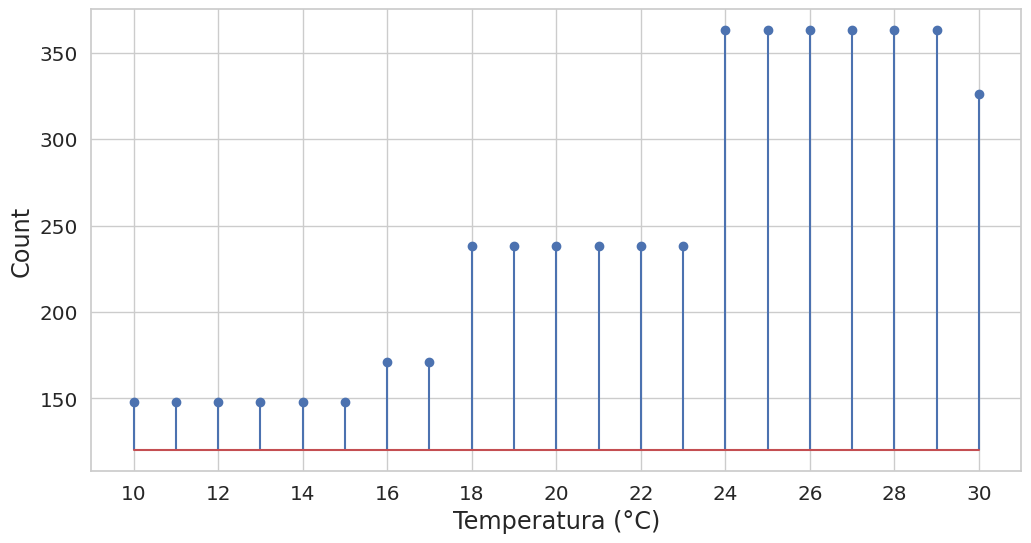

In [39]:
# Eliminar columnas no numéricas como 'datetime'
df_train_numeric = df_train.drop(columns=['datetime', 'casual', 'registered', 'count'])
X_prueba_numeric = X_prueba.drop(columns=['datetime', 'casual', 'registered', 'count'])

# Entrenar el modelo con los datos preprocesados
regressor.fit(df_train_numeric, y_train)

plt.figure(figsize=(12,6))
plt.stem(np.linspace(10,30,21),regressor.predict(X_prueba_numeric),bottom=120)
plt.xlabel('Temperatura (°C)',fontsize='x-large')
plt.ylabel('Count',fontsize='x-large')
plt.xticks(np.linspace(10,30,11),fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('cambios_temp.png')
plt.show()

 - Observe el cambio que genera la temperatura a la salida (en particular el pasar de una temperatura de 23°C a 24°C, puede variar según la semilla, ver **Nota**).

 - ¿Qué desventaja le encuenta a los árboles de decisión en comparación con modelos lineales?

 **Nota:** Debido a la alta varianza de los Árboles de decisión los modelos obtenidos pueden variar de gran manera a efecto de pequeños cambios en el entrenamiento. En la carpeta se adjunta la imagen *cambios_temp.png* para que pueda discutir las preguntas a partir de la figura que se espera obtener.

## Desventaja de los Árboles de Decisión en comparación con modelos lineales:

1. Alta varianza (sobreajuste):
Los Árboles de Decisión tienen una tendencia natural a ajustarse demasiado a los datos de entrenamiento, lo que puede llevar a un rendimiento deficiente en datos no vistos. Esto ocurre porque los árboles pueden capturar ruido en lugar de patrones generales. En contraste, los modelos lineales tienden a ser más simples y menos propensos al sobreajuste, ya que asumen relaciones lineales entre las variables.

2. Sensibilidad a pequeños cambios en los datos:
Árboles de Decisión son muy sensibles a pequeñas fluctuaciones en los datos de entrenamiento. Un pequeño cambio en los datos o en la semilla aleatoria puede generar árboles completamente diferentes, lo que lleva a resultados inconsistentes. Por ejemplo, en esta tarea, si cambiamos la semilla aleatoria, podríamos obtener una curva diferente para la relación entre temperatura y demanda.

3. Interpretabilidad limitada en casos complejos:
Aunque los Árboles de Decisión son interpretables en casos simples, en problemas complejos con muchas características y profundidades altas, pueden volverse difíciles de interpretar. Los modelos lineales, por otro lado, proporcionan coeficientes que facilitan la interpretación de la importancia relativa de cada característica.

4. No capturan relaciones lineales perfectamente:
Árboles de Decisión dividen el espacio de características mediante particiones jerárquicas, lo que puede hacer que sea difícil capturar relaciones lineales precisas. En contraste, los modelos lineales están diseñados específicamente para capturar relaciones lineales entre las variables.

5. Rendimiento en problemas con muchas características irrelevantes:
En problemas con muchas características irrelevantes, los Árboles de Decisión pueden gastar recursos en dividir características que no aportan información valiosa. Los modelos lineales, por otro lado, pueden manejar mejor estos casos mediante técnicas como la regularización, que penalizan características irrelevantes.

### Ajuste Fino

#### Objetivos

*   Seleccionar uno de los hiper-parámetros y encontrar el mejor estimador.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados anteriores.
*   Graficar cómo varían los valores de RMSLE de entrenamiento y validación, para diferentes valores del hiper-parámetro.
*   Mostrar el mejor valor RMSLE (promedio de todos los *folds*) y el valor del hiper-parámetro.
*   Visualizar el árbol hasta los nodos de profundidad 2 utilizando la función *plot_tree()*. Agrandar el tamaño de la imagen de manera de poder leer la descripción de cada nodo.
*   Analizar las decisiones que está tomando el árbol para los primeros nodos.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones.

**Nota:** Puede ser útil la función *save_gs_results()* que se encuentra en el archivo *comet_log.py* de la carpeta del taller para organizar sus experimentos con Comet.

In [87]:
# Definir valores posibles para max_depth
max_depth_values = range(1, 21)

# Listas para almacenar los resultados de RMSLE
rmsle_train_scores = []
rmsle_val_scores = []

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterar sobre cada valor de max_depth
for depth in max_depth_values:
    # Listas temporales para almacenar los scores de este fold
    train_scores_fold = []
    val_scores_fold = []

    for train_index, val_index in kf.split(X_train):
        # Separar los datos en entrenamiento y validación
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear el regresor base con el hiperparámetro actual
        base_regressor = DecisionTreeRegressor(max_depth=depth, random_state=2)
        regressor = TransformedTargetRegressor(
            regressor=base_regressor,
            func=np.log1p,  # Transformación logarítmica
            inverse_func=np.expm1  # Inversa de la transformación
        )

        # Entrenar el modelo
        regressor.fit(X_train_fold, y_train_fold)

        # Predecir en el conjunto de entrenamiento y validación
        y_pred_train = regressor.predict(X_train_fold)
        y_pred_val = regressor.predict(X_val_fold)

        # Calcular RMSLE para ambos conjuntos
        rmsle_train = rmsle(y_train_fold, y_pred_train)
        rmsle_val = rmsle(y_val_fold, y_pred_val)

        # Guardar los scores de este fold
        train_scores_fold.append(rmsle_train)
        val_scores_fold.append(rmsle_val)

    # Calcular la media de los scores para este valor de max_depth
    rmsle_train_scores.append(np.mean(train_scores_fold))
    rmsle_val_scores.append(np.mean(val_scores_fold))

# Encontrar el mejor valor de max_depth
best_max_depth = max_depth_values[np.argmin(rmsle_val_scores)]
best_rmsle_single_tree = np.min(rmsle_val_scores)

print(f"Mejor max_depth: {best_max_depth}")
print(f"Mejor RMSLE (promedio): {best_rmsle_single_tree:.4f}")

Mejor max_depth: 12
Mejor RMSLE (promedio): 0.3971


[np.float64(0.9163443704889541), np.float64(0.8420102226858965), np.float64(0.7507268585382458), np.float64(0.6772831919927877), np.float64(0.5896754718031408), np.float64(0.5302311433456988), np.float64(0.4684518372504147), np.float64(0.41225546084814424), np.float64(0.35080552576395835), np.float64(0.2913656527963412), np.float64(0.2438806866839033), np.float64(0.2010171240072073), np.float64(0.16590412915806874), np.float64(0.13512569668241298), np.float64(0.10885054060116144), np.float64(0.08686256592449725), np.float64(0.06921332381218162), np.float64(0.05491684163888348), np.float64(0.043539881534263566), np.float64(0.034590613880158015)]
[np.float64(0.9164155917371206), np.float64(0.8427294828970107), np.float64(0.7558604068838044), np.float64(0.6846899338312599), np.float64(0.598965246248626), np.float64(0.5467846761136704), np.float64(0.49902029757237737), np.float64(0.4624286021381316), np.float64(0.4326795261198823), np.float64(0.4039756600121273), np.float64(0.3979781455083

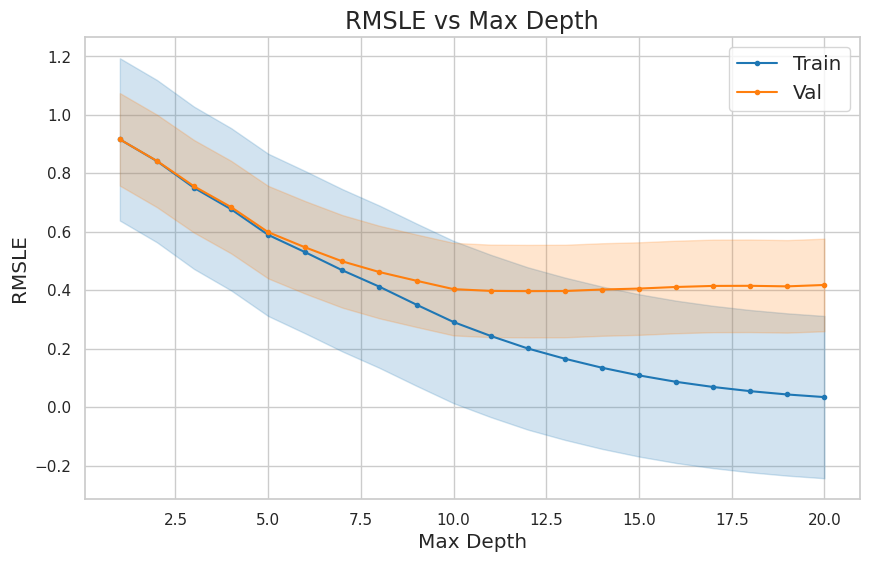

In [88]:
print(rmsle_train_scores)
print(rmsle_val_scores)
# Calcular media y desviación estándar
mean_rmsle_train = np.array(rmsle_train_scores)
std_rmsle_train = np.std(rmsle_train_scores, axis=0)
mean_rmsle_val = np.array(rmsle_val_scores)
std_rmsle_val = np.std(rmsle_val_scores, axis=0)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mean_rmsle_train, '.-', color='tab:blue', label='Train')
plt.plot(max_depth_values, mean_rmsle_val, '.-', color='tab:orange', label='Val')

# Agregar bandas de desviación estándar
plt.fill_between(max_depth_values, mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2, color='tab:blue')
plt.fill_between(max_depth_values, mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2, color='tab:orange')

# Configurar etiquetas y título
plt.xlabel('Max Depth', fontsize='large')
plt.ylabel('RMSLE', fontsize='large')
plt.title('RMSLE vs Max Depth', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

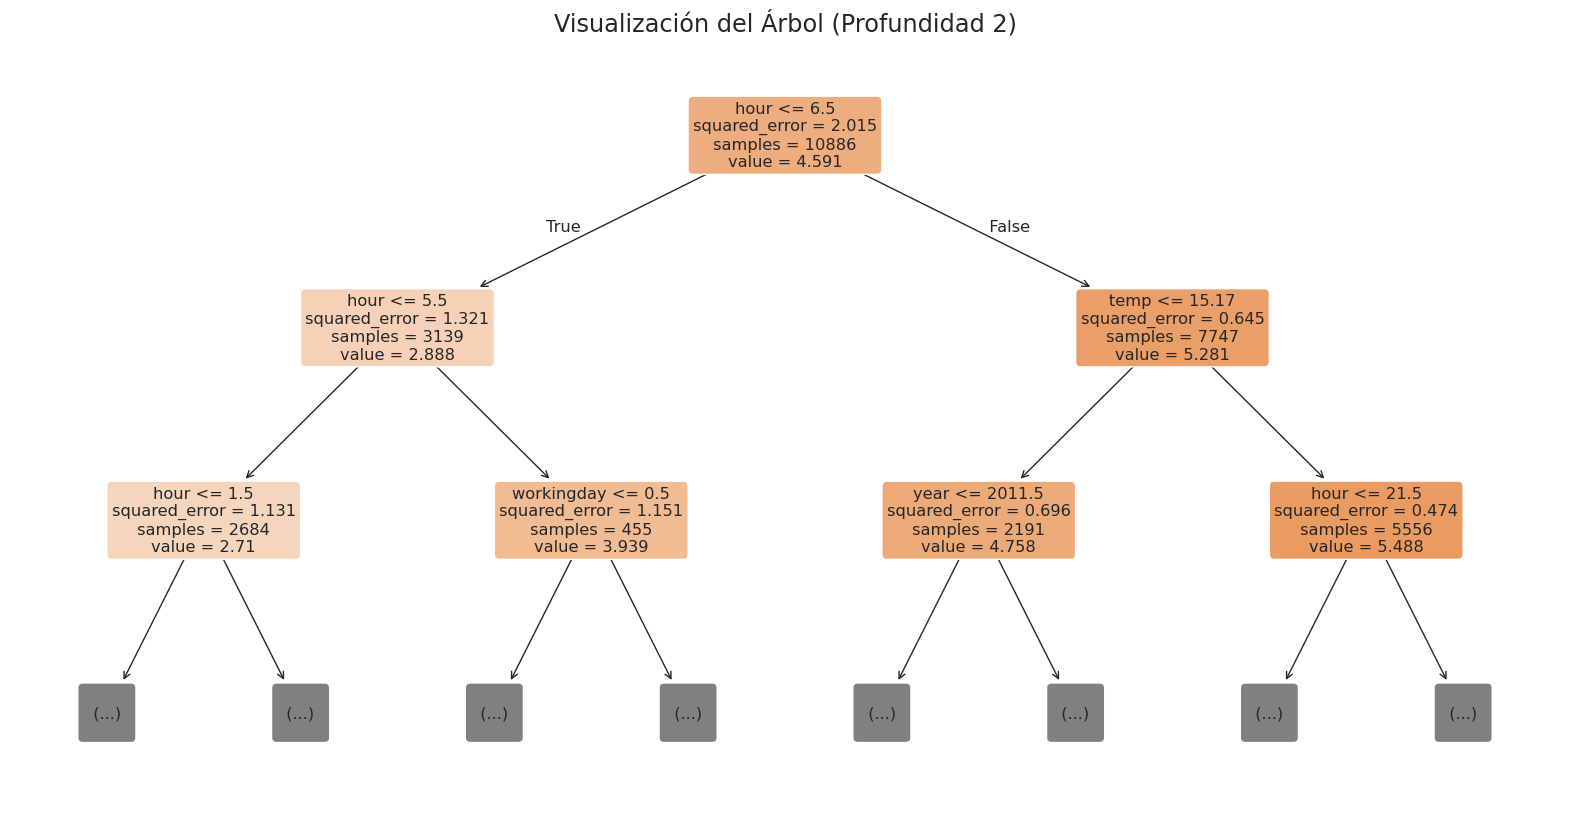

In [47]:
from sklearn.tree import plot_tree

# Entrenar el modelo con el mejor max_depth encontrado
best_regressor = DecisionTreeRegressor(max_depth=best_max_depth, random_state=2)
best_regressor = TransformedTargetRegressor(
    regressor=best_regressor,
    func=np.log1p,
    inverse_func=np.expm1
)
best_regressor.fit(X_train, y_train)

# Extraer el regresor base (DecisionTreeRegressor) del TransformedTargetRegressor
base_model = best_regressor.regressor_

# Visualizar el árbol hasta profundidad 2
plt.figure(figsize=(20, 10))  # Agrandar el tamaño de la imagen
plot_tree(base_model, feature_names=X_train.columns, filled=True, max_depth=2, rounded=True)
plt.title('Visualización del Árbol (Profundidad 2)', fontsize='x-large')
plt.show()

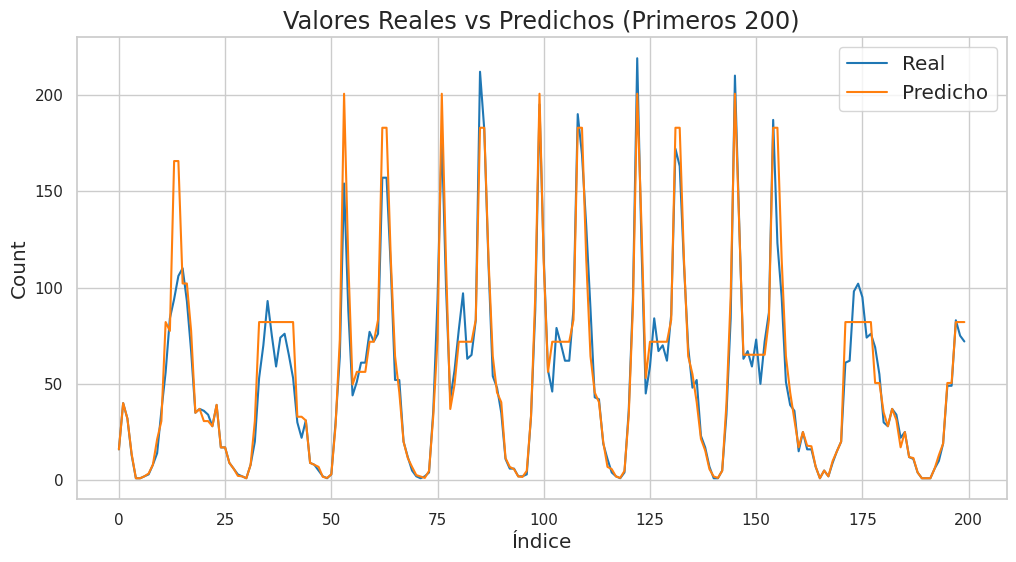

In [48]:
# Predecir los primeros 200 valores
y_pred = best_regressor.predict(X_train.iloc[:200])

# Graficar valores reales vs predichos
plt.figure(figsize=(12, 6))
plt.plot(range(200), y_train.iloc[:200], label='Real', color='tab:blue')
plt.plot(range(200), y_pred, label='Predicho', color='tab:orange')
plt.xlabel('Índice', fontsize='large')
plt.ylabel('Count', fontsize='large')
plt.title('Valores Reales vs Predichos (Primeros 200)', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

## Parte 5 - Random Forest

#### Preguntas sobre métodos de Ensamble:

*   ¿Cuáles son las ventajes de los métodos de Ensamble?
*   ¿A qué métodos de ensamble está asociado *Random Forest*?.
*   Importar la función *RandomForestRegressor()* de *Scikit-Learn*.
*   Indicar y describir los principales hiper-parámetros correspondientes a los métodos de ensamble que ofrece la función.




## 1. ¿Cuáles son las ventajas de los métodos de ensamble?

Los métodos de ensamble combinan múltiples modelos (llamados "estimadores base") para mejorar el rendimiento general del modelo. Las principales ventajas son:

Mejora en la precisión:
Los métodos de ensamble suelen superar a los modelos individuales porque promedian o combinan las predicciones de varios modelos, reduciendo errores.
Reducción del sobreajuste:
Al combinar múltiples modelos, los métodos de ensamble tienden a ser menos sensibles al ruido en los datos y evitan ajustarse demasiado a patrones irrelevantes.
Robustez:
Los métodos de ensamble son más robustos frente a variaciones en los datos, ya que diferentes modelos pueden capturar diferentes patrones en los datos.
Manejo de datos complejos:
Son especialmente útiles en problemas con relaciones no lineales o interacciones complejas entre características.
Flexibilidad:
Permiten usar diferentes tipos de modelos como estimadores base, lo que los hace adaptables a una amplia variedad de problemas.

---

## 2. ¿A qué métodos de ensamble está asociado Random Forest ?

Random Forest está asociado al método de ensamble conocido como Bagging (Bootstrap Aggregating). Este método funciona de la siguiente manera:

Bootstrap Sampling:
Se generan múltiples subconjuntos de datos mediante muestreo aleatorio con reemplazo. Cada subconjunto se usa para entrenar un modelo (árbol de decisión en el caso de Random Forest).
Agregación:
Las predicciones de todos los modelos se combinan (por ejemplo, mediante promedio en regresión o votación mayoritaria en clasificación) para producir la salida final.
Además, Random Forest introduce una mejora adicional al método de Bagging:

Selección aleatoria de características:
En cada división del árbol, solo se considera un subconjunto aleatorio de características. Esto reduce la correlación entre los árboles y mejora la diversidad del modelo.

In [49]:
from sklearn.ensemble import RandomForestRegressor

### Principales hiperparámetros de `RandomForestRegressor`

La función `RandomForestRegressor()` ofrece varios hiperparámetros que controlan el comportamiento del modelo. A continuación, se describen los más importantes relacionados con los métodos de ensamble:

---

#### a) `n_estimators`
- **Descripción:** Número de árboles en el bosque.
- **Efecto:** Un mayor número de árboles mejora la precisión, pero también aumenta el tiempo de entrenamiento. Sin embargo, después de cierto punto, agregar más árboles tiene un impacto marginal en el rendimiento.
- **Valor común:** `100` es un valor predeterminado razonable.

---

#### b) `max_features`
- **Descripción:** Número máximo de características consideradas para dividir cada nodo.
- **Efecto:** Controla la diversidad entre los árboles. Un valor menor reduce la correlación entre los árboles, mejorando el rendimiento del modelo.
- **Valores comunes:**
  - `'auto'`: Usa la raíz cuadrada del número total de características.
  - `'sqrt'`: Equivalente a `'auto'`.
  - `'log2'`: Usa el logaritmo base 2 del número total de características.

---

#### c) `bootstrap`
- **Descripción:** Indica si se utiliza bootstrap sampling (muestreo con reemplazo) para generar los subconjuntos de datos.
- **Efecto:** Si `True`, cada árbol se entrena con un subconjunto diferente de datos. Si `False`, todos los árboles ven los mismos datos.
- **Valor predeterminado:** `True`.

---

#### d) `max_depth`
- **Descripción:** Profundidad máxima de cada árbol.
- **Efecto:** Limita la complejidad de los árboles y ayuda a prevenir el sobreajuste.
- **Valor común:** Depende del problema, pero valores como `10` o `20` suelen ser buenos puntos de partida.

---

#### e) `min_samples_split`
- **Descripción:** Número mínimo de muestras requeridas para dividir un nodo.
- **Efecto:** Incrementar este valor reduce la profundidad de los árboles y previene el sobreajuste.
- **Valor predeterminado:** `2`.

---

#### f) `min_samples_leaf`
- **Descripción:** Número mínimo de muestras requeridas para ser un nodo hoja.
- **Efecto:** Incrementar este valor reduce el sobreajuste al evitar que los nodos terminales sean demasiado específicos.
- **Valor predeterminado:** `1`.

---

#### g) `random_state`
- **Descripción:** Semilla aleatoria para reproducibilidad.
- **Efecto:** Asegura que los resultados sean consistentes entre ejecuciones.
- **Valor común:** Cualquier entero, por ejemplo, `42`.

---

#### h) `n_jobs`
- **Descripción:** Número de núcleos de CPU utilizados para el entrenamiento en paralelo.
- **Efecto:** Acelera el entrenamiento cuando hay muchos árboles.
- **Valor común:** `-1` (usa todos los núcleos disponibles).

#### Ajuste fino



*   Encontrar el mejor estimador para *Random Forest* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados correspondientes de la parte 4.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con el de la parte 4. Mostrar los valores seleccionados de los hiper-parámetros.
*   ¿Qué ventaja se pierde con repecto a usar un sólo árbol?
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con el gráfico correspondiente de la parte 4.
*   Mostrar la importancia de cada característica utilizando la variable *feature_importances_*.



In [86]:
# Diccionario para almacenar los resultados
results = {}

# Definir valores posibles para n_estimators y max_features
n_estimators_values = [50, 100, 150, 200, 300]
max_features_values = ['sqrt', 'log2', None]

# Inicializar mejor RMSLE y mejores parámetros
best_rmsle = float('inf')  # Inicializar con un valor muy grande
best_params = {}           # Inicializar como un diccionario vacío

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterar sobre combinaciones de hiperparámetros
for n_estimators in n_estimators_values:
    for max_features in max_features_values:
        train_scores_fold = []
        val_scores_fold = []

        for train_index, val_index in kf.split(X_train):
            # Separar los datos en entrenamiento y validación
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Crear el regresor base (Random Forest)
            base_regressor = RandomForestRegressor(
                n_estimators=n_estimators,
                max_features=max_features,
                max_depth=best_max_depth,
                random_state=42,
                n_jobs=-1
            )

            # Aplicar transformaciones al objetivo
            regressor = TransformedTargetRegressor(
                regressor=base_regressor,
                func=np.log1p,       # Transformación logarítmica
                inverse_func=np.expm1  # Inversa de la transformación
            )

            # Entrenar el modelo
            regressor.fit(X_train_fold, y_train_fold)

            # Predecir en el conjunto de entrenamiento y validación
            y_pred_train = regressor.predict(X_train_fold)
            y_pred_val = regressor.predict(X_val_fold)

            # Calcular RMSLE para ambos conjuntos
            rmsle_train = rmsle(y_train_fold, y_pred_train)
            rmsle_val = rmsle(y_val_fold, y_pred_val)

            # Guardar los scores de este fold
            train_scores_fold.append(rmsle_train)
            val_scores_fold.append(rmsle_val)

        # Calcular la media de los scores para esta combinación de hiperparámetros
        mean_rmsle_train = np.mean(train_scores_fold)
        mean_rmsle_val = np.mean(val_scores_fold)

        # Almacenar los resultados en el diccionario
        results[(n_estimators, max_features)] = {
            'mean_rmsle_train': mean_rmsle_train,
            'mean_rmsle_val': mean_rmsle_val
        }

        # Imprimir resultados intermedios para depuración
        print(f"n_estimators={n_estimators}, max_features={max_features}: "
              f"RMSLE (train)={mean_rmsle_train:.4f}, "
              f"RMSLE (val)={mean_rmsle_val:.4f}")

        # Actualizar los mejores parámetros si encontramos un nuevo mínimo
        if mean_rmsle_val < best_rmsle:
            best_rmsle = mean_rmsle_val
            best_params = {'n_estimators': n_estimators, 'max_features': max_features}

# Mostrar los mejores parámetros y el mejor RMSLE
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor RMSLE (promedio): {best_rmsle:.4f}")

n_estimators=50, max_features=sqrt: RMSLE (train)=0.3156, RMSLE (val)=0.4356
n_estimators=50, max_features=log2: RMSLE (train)=0.3156, RMSLE (val)=0.4356
n_estimators=50, max_features=None: RMSLE (train)=0.1838, RMSLE (val)=0.3064
n_estimators=100, max_features=sqrt: RMSLE (train)=0.3143, RMSLE (val)=0.4329
n_estimators=100, max_features=log2: RMSLE (train)=0.3143, RMSLE (val)=0.4329
n_estimators=100, max_features=None: RMSLE (train)=0.1821, RMSLE (val)=0.3051
n_estimators=150, max_features=sqrt: RMSLE (train)=0.3133, RMSLE (val)=0.4326
n_estimators=150, max_features=log2: RMSLE (train)=0.3133, RMSLE (val)=0.4326
n_estimators=150, max_features=None: RMSLE (train)=0.1816, RMSLE (val)=0.3044
n_estimators=200, max_features=sqrt: RMSLE (train)=0.3115, RMSLE (val)=0.4304
n_estimators=200, max_features=log2: RMSLE (train)=0.3115, RMSLE (val)=0.4304
n_estimators=200, max_features=None: RMSLE (train)=0.1813, RMSLE (val)=0.3041
n_estimators=300, max_features=sqrt: RMSLE (train)=0.3121, RMSLE (v

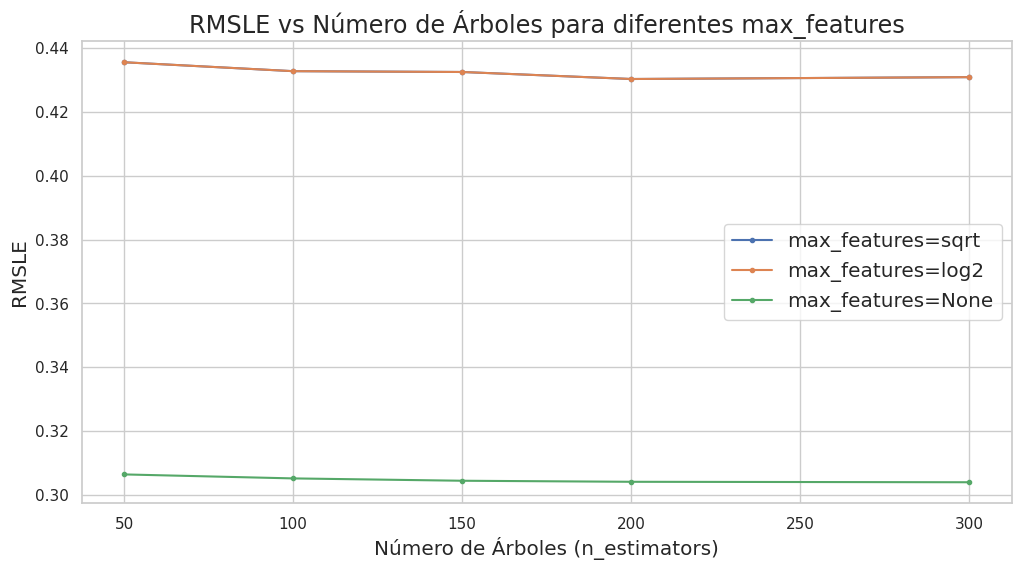

In [78]:
# Extraer los datos para graficar
plt.figure(figsize=(12, 6))

# Iterar sobre cada valor de max_features
for max_features in max_features_values:
    rmsle_val_scores_for_max_features = [
        results[(n_estimators, max_features)]['mean_rmsle_val']
        for n_estimators in n_estimators_values
    ]
    plt.plot(n_estimators_values, rmsle_val_scores_for_max_features, '.-', label=f'max_features={max_features}')

# Configurar etiquetas y título
plt.xlabel('Número de Árboles (n_estimators)', fontsize='large')
plt.ylabel('RMSLE', fontsize='large')
plt.title('RMSLE vs Número de Árboles para diferentes max_features', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

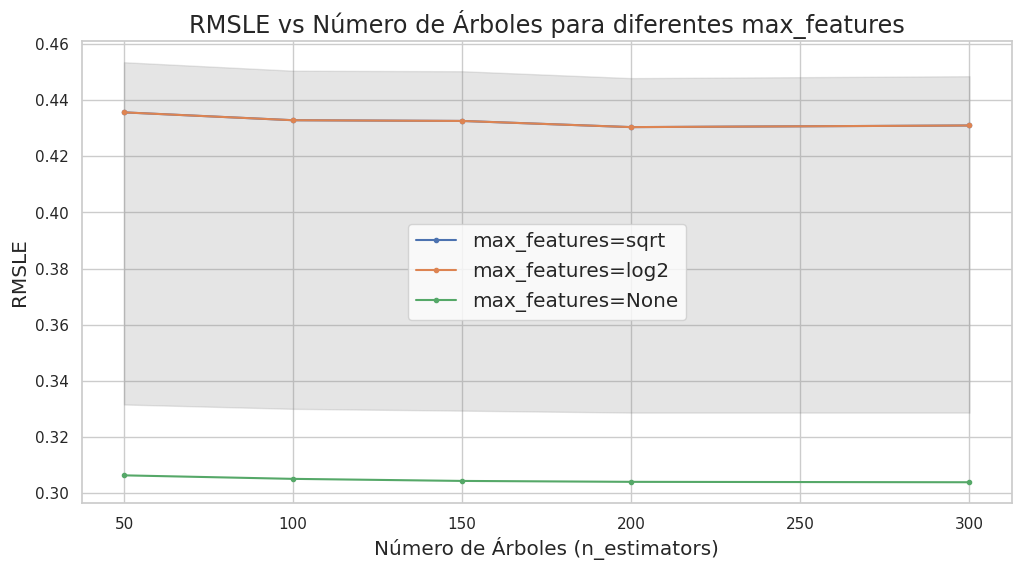

[0.06093252 0.06020322 0.06042918 0.05954649 0.05988839]
[0.39256298 0.39027992 0.38986471 0.38828964 0.38862916]


In [82]:
# Extraer los datos para graficar
plt.figure(figsize=(12, 6))

# Iterar sobre cada valor de max_features
for max_features in max_features_values:
    rmsle_val_scores_for_max_features = [
        results[(n_estimators, max_features)]['mean_rmsle_val']
        for n_estimators in n_estimators_values
    ]
    plt.plot(n_estimators_values, rmsle_val_scores_for_max_features, '.-', label=f'max_features={max_features}')


std_rmsle_val = np.array([
    [results[(n_estimators, max_features)]['mean_rmsle_val'] for n_estimators in n_estimators_values]
    for max_features in max_features_values
]).std(axis=0)
mean_rmsle_val = np.array([
    [results[(n_estimators, max_features)]['mean_rmsle_val'] for n_estimators in n_estimators_values]
    for max_features in max_features_values
]).mean(axis=0)

# Agregar bandas de desviación estándar
plt.fill_between(n_estimators_values,
                 mean_rmsle_val + std_rmsle_val,
                 mean_rmsle_val - std_rmsle_val,
                 alpha=0.2, color='gray')

# Configurar etiquetas y título
plt.xlabel('Número de Árboles (n_estimators)', fontsize='large')
plt.ylabel('RMSLE', fontsize='large')
plt.title('RMSLE vs Número de Árboles para diferentes max_features', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()
print(std_rmsle_val)
print(mean_rmsle_val)

In [89]:
# Resultados del árbol de decisión único (Parte 4)
print("Resultados del árbol de decisión único:")
print(f"Mejor max_depth: {best_max_depth}")
print(f"Mejor RMSLE (promedio): {best_rmsle_single_tree:.4f}")

# Resultados de Random Forest
print("\nResultados de Random Forest:")
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor RMSLE (promedio): {best_rmsle:.4f}")

# Comparación directa
if best_rmsle < best_rmsle_single_tree:
    print("\nRandom Forest tiene un mejor desempeño que el árbol de decisión único.")
else:
    print("\nEl árbol de decisión único tiene un mejor desempeño que Random Forest.")

Resultados del árbol de decisión único:
Mejor max_depth: 12
Mejor RMSLE (promedio): 0.3971

Resultados de Random Forest:
Mejores hiperparámetros: {'n_estimators': 300, 'max_features': None}
Mejor RMSLE (promedio): 0.3039

Random Forest tiene un mejor desempeño que el árbol de decisión único.


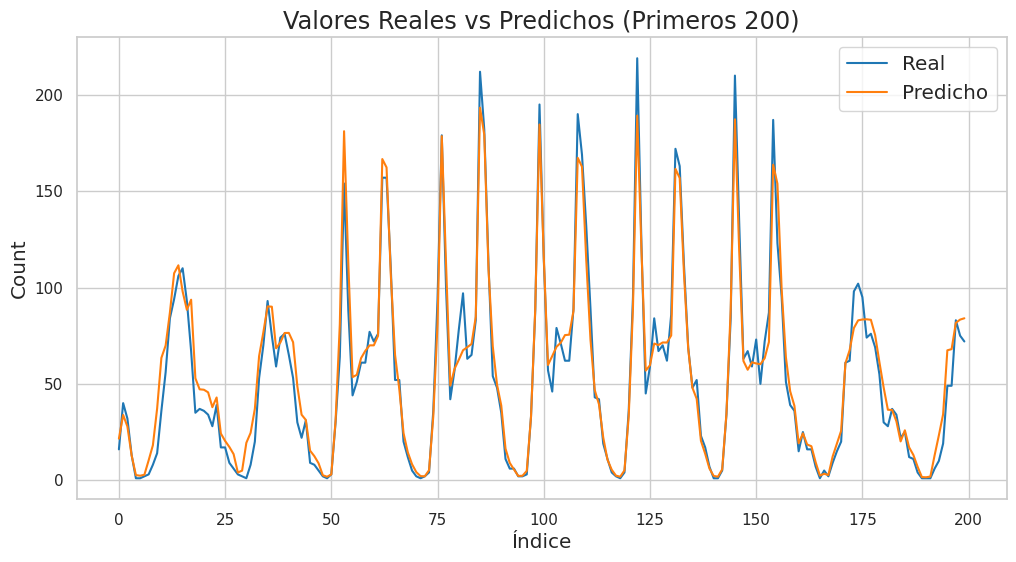

In [90]:
# Entrenar el modelo final con los mejores hiperparámetros
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_max_depth,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

# Predecir los primeros 200 valores
y_pred = final_model.predict(X_train.iloc[:200])

# Graficar valores reales vs predichos
plt.figure(figsize=(12, 6))
plt.plot(range(200), y_train.iloc[:200], label='Real', color='tab:blue')
plt.plot(range(200), y_pred, label='Predicho', color='tab:orange')
plt.xlabel('Índice', fontsize='large')
plt.ylabel('Count', fontsize='large')
plt.title('Valores Reales vs Predichos (Primeros 200)', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

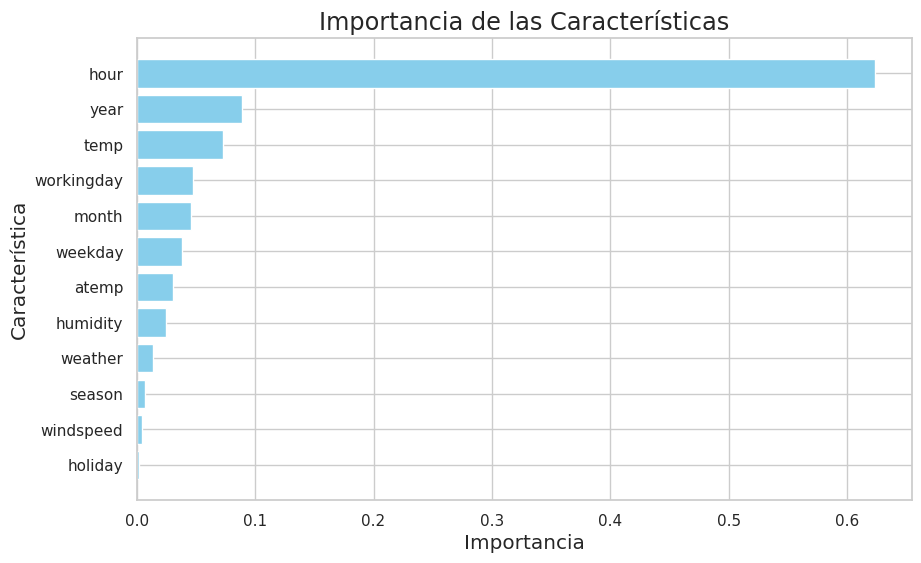

In [91]:
# Obtener la importancia de las características
importances = final_model.feature_importances_
feature_names = X_train.columns

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia', fontsize='large')
plt.ylabel('Característica', fontsize='large')
plt.title('Importancia de las Características', fontsize='x-large')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la característica más importante arriba
plt.grid(True)
plt.show()

## Parte 6 - Gradient Boosting

#### XGBoost

*   Indicar cuál es la principal diferencia entre *Bagging* y *Boosting*.
*   Importar la función *XGBRegressor()* de la librería [*xgboost*](https://github.com/dmlc/xgboost).
*   Este estimador a diferencia de los anteriores puede devolver predicciones negativas para estos datos. Indicar en que caso se pueda dar esto y por qué esto no sucedía con los estimadores anteriores.
*   Las predicciones negativas no pueden ser evaluadas por RMSLE. Por lo tanto, crear una nueva función de evaluación que fuerce a cero todos los valores negativos de las predicciones y luego calcule el valor de RMSLE. Para esto se debe utilizar la función *make_score* de *Sickit-Learn*, para que la nueva función pueda ser utilizada en las funciones de selección de modelos.


**Nota:** *Scikit-Learn* ofrece una implementación de *Gradient Boosting*, pero *XGBRegressor()* es la implementación de [*eXtreme Gradient Boosting*](https://arxiv.org/pdf/1603.02754.pdf?__hstc=133736337.1bb630f9cde2cb5f07430159d50a3c91.1513641600097.1513641600098.1513641600099.1&__hssc=133736337.1.1513641600100&__hsfp=528229161) un variante del algoritmo tradicional que dentro de algunas ventajas requiere menos tiempo de entrenamiento. La implementación de las funciones de la librería son muy similares a las de *Scikit-Learn*, de igual forma aquí le dejamos un [ejemplo](https://www.kaggle.com/alexisbcook/xgboost) de cómo usarla.







**Nota:** A partir de la versión **0.21** *Scikit-Learn* también ofrece una implementación de *Gradient Boosting* optimizada para data-sets grandes: [Histogram-based Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html). Su funcionamiento se basa en agrupar en *bins* a los features de entrada, remplazandolos por integers. El número de *bins* es controlado por el hiperparámetro *max_bins*, el cual por defecto toma el valor 255 y no puede ser seteado a un valor mayor que este. En el Capítulo 7 del libro se encuentra más información acerca de este algoritmo.

##1. ¿Cuál es la principal diferencia entre Bagging y Boosting ?

Bagging (como en Random Forest):
Entrena múltiples modelos independientemente en subconjuntos aleatorios de los datos (con reemplazo).
Combina las predicciones mediante promedio o votación.
Reduce la varianza del modelo, lo que ayuda a prevenir el sobreajuste.
Boosting (como en XGBoost):
Entrena modelos secuencialmente , donde cada modelo intenta corregir los errores del anterior.
Combina las predicciones ponderando más fuertemente a los modelos que mejoran el rendimiento.
Reduce el sesgo del modelo, pero puede ser más propenso al sobreajuste si no se ajustan bien los hiperparámetros.
La principal diferencia es que Bagging construye modelos independientes , mientras que Boosting construye modelos secuenciales dependientes .

In [93]:
!pip install xgboost
from xgboost import XGBRegressor

##3. ¿Por qué XGBoost puede devolver predicciones negativas?

Caso en que ocurre:
XGBoost puede devolver predicciones negativas cuando los datos tienen valores pequeños o cercanos a cero, y el modelo no está restringido para evitar predicciones fuera del rango esperado.
Razón:
Los modelos anteriores (DecisionTreeRegressor y RandomForestRegressor) son inherentemente no paramétricos y no asumen una distribución específica para las predicciones. Además, al usar transformaciones como TransformedTargetRegressor, se estabilizaban los valores del objetivo evitando predicciones negativas.
En cambio, XGBoost utiliza un enfoque basado en gradientes que minimiza una función de pérdida sin restricciones explícitas sobre el rango de las predicciones, lo que puede llevar a valores negativos.

In [94]:
from sklearn.metrics import make_scorer

# Función personalizada para RMSLE con corrección de valores negativos
def rmsle_with_clipping(y_true, y_pred):
    # Forzar valores negativos a cero
    y_pred = np.clip(y_pred, 0, None)
    # Calcular RMSLE
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Crear un scorer personalizado para usar en validación cruzada
rmsle_scorer = make_scorer(rmsle_with_clipping, greater_is_better=False)

#### Ajuste fino



*   Encontrar el mejor estimador para *Gradient Boosting* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los gráficos correspondientes.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con los anteriores. Mostrar los valores seleccionados de los hiper-parámetros.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con los gráficos corespondientes.
*   ¿Qué compromiso hay entre los hiper-parámetros *n_estimators* y *learning_rate*?



In [100]:
from sklearn.model_selection import GridSearchCV

# Definir valores posibles para hiperparámetros de XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [best_max_depth],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Crear el modelo XGBoost
xgb_model = XGBRegressor(random_state=42)

# Configurar la búsqueda de hiperparámetros con la función de evaluación personalizada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmsle_scorer,  # Usar el scorer personalizado
    cv=kf,
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con validación cruzada
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y el mejor RMSLE
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor RMSLE (promedio):", -grid_search.best_score_)  # Negativo porque scoring minimiza

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100, 'subsample': 0.8}
Mejor RMSLE (promedio): 0.3168429901671549


In [ ]:
from sklearn.model_selection import cross_val_predict

# Extraer los resultados de la búsqueda de hiperparámetros
results = grid_search.cv_results_

# Organizar los datos para graficar
plt.figure(figsize=(12, 6))

# Iterar sobre cada valor de learning_rate
for learning_rate in param_grid['learning_rate']:
    mean_rmsle_scores = []  # Para almacenar las medias de RMSLE
    std_rmsle_scores = []   # Para almacenar las desviaciones estándar de RMSLE

    for n_estimators in param_grid['n_estimators']:
        # Filtrar los resultados para este learning_rate y n_estimators
        filtered_scores = []
        for i, params in enumerate(results['params']):
            if (params['learning_rate'] == learning_rate and
                params['n_estimators'] == n_estimators):
                # Entrenar un modelo con estos hiperparámetros
                model = XGBRegressor(
                    n_estimators=params['n_estimators'],
                    max_depth=params['max_depth'],
                    learning_rate=params['learning_rate'],
                    subsample=params['subsample'],
                    random_state=42
                )

                # Obtener predicciones usando validación cruzada
                y_pred = cross_val_predict(model, X_train, y_train, cv=kf)

                # Calcular RMSLE usando la función personalizada
                rmsle_score = rmsle_with_clipping(y_train, y_pred)
                filtered_scores.append(rmsle_score)

        # Calcular la media y la desviación estándar de las puntuaciones filtradas
        if len(filtered_scores) > 0:
            mean_rmsle_scores.append(np.mean(filtered_scores))  # Media
            std_rmsle_scores.append(np.std(filtered_scores))    # Desviación estándar

    # Graficar los resultados para este learning_rate
    plt.plot(param_grid['n_estimators'], mean_rmsle_scores, '.-', label=f'Learning Rate={learning_rate}')

    # Agregar bandas de desviación estándar
    plt.fill_between(
        param_grid['n_estimators'],
        np.array(mean_rmsle_scores) + np.array(std_rmsle_scores),  # Media + desviación estándar
        np.array(mean_rmsle_scores) - np.array(std_rmsle_scores),  # Media - desviación estándar
        alpha=0.2  # Transparencia
    )

# Configurar etiquetas y título
plt.xlabel('Número de Árboles (n_estimators)', fontsize='large')
plt.ylabel('RMSLE', fontsize='large')
plt.title('RMSLE vs Número de Árboles para diferentes Learning Rates', fontsize='x-large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

## Parte 7 - Custom Transformers

- Construir un *Custom Transformer* que extraiga las caracterísicas temporales, siguiendo el ejemplo del capítulo 2 del libro.

## Parte 8 - Generar un modelo

#### Objetivos:

 - Generar el mejor modelo posible. Se podrá explorar posibles mejoras en cualquiera de las siguientes etapas:

    - Parámetros óptimos del regresor.
    - Predicción de alquileres registered y casual por separado.
    - Separación de conjunto de Entrenamiento y Validación tomando en cuenta la generación del conjunto de Test del desafío.
    - Cambios en las características utilizadas. (Agregando o quitando alguna de ellas)

## Parte 9 - Submit
Construir un *pipeline* para el estimador que consideren que tuvo mejor desempeño. El pre-procesamiento debe incluir la extracción de las nuevas características.

Subir los resultados del *pipeline* para los datos de *test*,  a la [página](https://www.kaggle.com/c/bike-sharing-demand/submissions) de la competencia.



*   ¿Cuánto fue el valor de RMSLE para el conjunto de test?
